# Metrics visualisation and conclusion

As benchmark model in order to measure the performance of all trained models, I’ll be instantiating each model to generate 639 images (we have this number of MRIs in the test folder), giving each folder the name of the corresponding model used. After that, I’ll be computing __Fréchet Inception Distance (FID)__ scores (GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium) using __[pytorch-fid](https://github.com/mseitzer/pytorch-fid)__, by selecting all real images from the test folder, and executing FID with each pair of real and generated images.

After generating all these images, we will see some samples, and plot all FID metrics and describe the differences observed. The goal is to assert if the usage of ensembles, and which type of ensemble, improves generated image quality, which model generated more similar images than the rest?.

In [1]:
import os
import time
import glob
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl
import numpy as np
from PIL import Image, ImageOps
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir
from os.path import isfile, join

# metrics helpers
from commons.utils import is_train_on_gpu
from commons import gan_models

In [2]:
# hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 200
img_size = 128

In [3]:
def get_groups_len(sample_size, chunks):
    '''generate a list where each position is the length that group should have
       the idea is to loop over that list and generate a number of samples given by that length'''
    lengths = []
    groups_elem = np.arange(sample_size)
    for group in np.array_split(groups_elem, chunks):
        lengths.append(len(group))
    return lengths

def grayimg2disk(img, img_path):
    '''save a single numpy image to disk'''
    # src: https://stackoverflow.com/questions/26929052/how-to-save-an-array-as-a-grayscale-image-with-matplotlib-numpy
    print(f'* saving sample image: {img_path}')
    img = img.detach().cpu().numpy()
    img_gray = (((img - img.min()) / (img.max() - img.min())) * 255.9).astype(np.uint8)
    image_gray = Image.fromarray(img_gray[0])
    image_gray.save(img_path)

def save_samples_to_disk_imgs(samples, folder_path):
    '''save a set of tensor images to disk'''
    print('save_samples_to_disk_imgs', samples.shape)
    for idx, img in enumerate(samples):
        img_path = f'{folder_path}/{idx}.png'
        grayimg2disk(img, img_path)

In [4]:
class GeneratorEnsemble:
    def __init__(self, model_name, models_folder):
        self.model_name = model_name
        self.models_folder = models_folder

        model_files_list = [f for f in listdir(self.models_folder) if isfile(join(self.models_folder, f))]
        self.models_path = [f'{self.models_folder}/{f}' for f in model_files_list]
        
        self.samples_folder = f'metrics/samples/{model_name}'
        self.samples_rand_folder = f'metrics/samples_random/{model_name}'
                
    def load(self):
        self.generators = []
        
        for mod_path in self.models_path:
            print(f'> loading model {mod_path}')
            _, generator = gan_models.build_network(d_conv_dim, g_conv_dim, z_size)
            device = torch.device("cuda")
            generator.load_state_dict(torch.load(mod_path))
            generator.to(device)
            self.generators.append(generator)
        print(f'>>> all {self.model_name} generators instanciated')
    
    def generate_samples(self, sample_size):
        '''generate samples using all generators in ensemble uniformly'''
        generators_len = len(self.generators)
        chunk_size = int(sample_size / generators_len)
        
        print(f' > uniform generation of samples started with {self.model_name}')
        samples = torch.empty(0, 0, 0, 0)
        for gen_idx, sample_group_len in enumerate(get_groups_len(sample_size, generators_len)):
            fixed_z = np.random.uniform(-1, 1, size=(sample_group_len, z_size))
            fixed_z = torch.from_numpy(fixed_z).float()
            if is_train_on_gpu:
                fixed_z = fixed_z.cuda()
            
            print(f' * generating {sample_group_len} samples with {self.model_name}[{gen_idx}]')
            samples_group = self.generators[gen_idx](fixed_z)
            # concat samples group
            is_samples_empty = samples.nelement() == 0
            samples = samples_group if is_samples_empty else torch.cat((samples, samples_group), 0)

        print(f' > {samples.shape[0]} samples uniformly generated with {self.model_name}')
        return samples
    
    def generate_samples_rand(self, sample_size):
        '''generate samples randomly choosing a generator from ensemble'''
        generators_len = len(self.generators)
        gen_rand_selections = np.random.randint(0, generators_len, sample_size)
            
        print(f' > random generation of samples started with {self.model_name}')
        samples = torch.empty(0, 0, 0, 0)
        for gen_idx in range(0, generators_len):
            sample_group_len = len(np.where(gen_rand_selections == gen_idx)[0])
            fixed_z = np.random.uniform(-1, 1, size=(sample_group_len, z_size))
            fixed_z = torch.from_numpy(fixed_z).float()
            if is_train_on_gpu:
                fixed_z = fixed_z.cuda()
            
            print(f' * generating {sample_group_len} samples with {self.model_name}[{gen_idx}]')
            samples_group = self.generators[gen_idx](fixed_z)
            # concat samples group
            is_samples_empty = samples.nelement() == 0
            samples = samples_group if is_samples_empty else torch.cat((samples, samples_group), 0)

        print(f' > {samples.shape[0]} samples randomly generated with {self.model_name}')
        return samples

class GeneratorControl:
    def __init__(self, model_name='cm35', model_folder='cm/models'):
        self.model_name = model_name # target defined epoch
        self.model_folder = model_folder
        self.model_path = f'{self.model_folder}/{model_name}'
        self.samples_folder = 'metrics/samples/cm'
                
    def load(self):
        print(f'> loading model {self.model_path}')
        _, generator = gan_models.build_network(d_conv_dim, g_conv_dim, z_size)
        device = torch.device("cuda")
        generator.load_state_dict(torch.load(self.model_path))
        generator.to(device)
        self.generator = generator
        print(f'> {self.model_name} generator instanciated')
    
    def generate_samples(self, sample_size):
        fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
        fixed_z = torch.from_numpy(fixed_z).float()
        if is_train_on_gpu:
            fixed_z = fixed_z.cuda()
        print(f" * generating {sample_size} samples with {self.model_name}")
        samples = self.generator(fixed_z)
        print(f' > {samples.shape[0]} samples generated with {self.model_name}')
        return samples

In [5]:
models_folder_list = ['em1/models', 'em2/models', 'em3/models']
model_names_list = ['egan', 'segan', 'cgan']

ensembles_list = []
for idx, model_name in enumerate(model_names_list):
    model_folder = models_folder_list[idx]
    gen_ensemble = GeneratorEnsemble(model_name, model_folder)
    gen_ensemble.load()
    ensembles_list.append(gen_ensemble)

> loading model em1/models/egan3
> loading model em1/models/egan2
> loading model em1/models/egan6
> loading model em1/models/egan8
> loading model em1/models/egan4
> loading model em1/models/egan5
> loading model em1/models/egan7
> loading model em1/models/egan1
>>> all egan generators instanciated
> loading model em2/models/segan52
> loading model em2/models/segan46
> loading model em2/models/segan39
> loading model em2/models/segan49
> loading model em2/models/segan43
> loading model em2/models/segan62
> loading model em2/models/segan65
>>> all segan generators instanciated
> loading model em3/models/cgan6
> loading model em3/models/cgan3
> loading model em3/models/cgan2
> loading model em3/models/cgan7
> loading model em3/models/cgan4
> loading model em3/models/cgan5
> loading model em3/models/cgan1
> loading model em3/models/cgan8
>>> all cgan generators instanciated


In [6]:
gen_control = GeneratorControl()
gen_control.load()

> loading model cm/models/cm35
> cm35 generator instanciated


In [7]:
# metrics params
number_of_samples = 639 # as many as images in the test set

In [8]:
# clean folders before generation
!rm -rf metrics/originals
!rm -rf metrics/samples/cm
!rm -rf metrics/samples/egan
!rm -rf metrics/samples/segan
!rm -rf metrics/samples/cgan
!rm -rf metrics/samples_random/egan
!rm -rf metrics/samples_random/segan
!rm -rf metrics/samples_random/cgan
!mkdir -p metrics/originals/test
!mkdir -p metrics/originals/train
!mkdir -p metrics/samples/cm
!mkdir -p metrics/samples/egan
!mkdir -p metrics/samples/segan
!mkdir -p metrics/samples/cgan
!mkdir -p metrics/samples_random/egan
!mkdir -p metrics/samples_random/segan
!mkdir -p metrics/samples_random/cgan

In [9]:
# generate control model samples
control_samples = gen_control.generate_samples(number_of_samples)
save_samples_to_disk_imgs(control_samples, f'{gen_control.samples_folder}')
del control_samples
torch.cuda.empty_cache()

# generate ensemble models samples uniformly
for idx, gen_ensemble in enumerate(ensembles_list):
    ensemble_samples = gen_ensemble.generate_samples(number_of_samples)
    save_samples_to_disk_imgs(ensemble_samples, f'{gen_ensemble.samples_folder}')
    del ensemble_samples
    torch.cuda.empty_cache()

# generate ensemble models samples randomly¡
for idx, gen_ensemble in enumerate(ensembles_list):
    ensemble_samples = gen_ensemble.generate_samples_rand(number_of_samples)
    save_samples_to_disk_imgs(ensemble_samples, f'{gen_ensemble.samples_rand_folder}')
    del ensemble_samples
    torch.cuda.empty_cache()

print('all samples generated!')

 * generating 639 samples with cm35
 > 639 samples generated with cm35
save_samples_to_disk_imgs torch.Size([639, 1, 128, 128])
* saving sample image: metrics/samples/cm/0.png
* saving sample image: metrics/samples/cm/1.png
* saving sample image: metrics/samples/cm/2.png
* saving sample image: metrics/samples/cm/3.png
* saving sample image: metrics/samples/cm/4.png
* saving sample image: metrics/samples/cm/5.png
* saving sample image: metrics/samples/cm/6.png
* saving sample image: metrics/samples/cm/7.png
* saving sample image: metrics/samples/cm/8.png
* saving sample image: metrics/samples/cm/9.png
* saving sample image: metrics/samples/cm/10.png
* saving sample image: metrics/samples/cm/11.png
* saving sample image: metrics/samples/cm/12.png
* saving sample image: metrics/samples/cm/13.png
* saving sample image: metrics/samples/cm/14.png
* saving sample image: metrics/samples/cm/15.png
* saving sample image: metrics/samples/cm/16.png
* saving sample image: metrics/samples/cm/17.png


* saving sample image: metrics/samples/cm/346.png
* saving sample image: metrics/samples/cm/347.png
* saving sample image: metrics/samples/cm/348.png
* saving sample image: metrics/samples/cm/349.png
* saving sample image: metrics/samples/cm/350.png
* saving sample image: metrics/samples/cm/351.png
* saving sample image: metrics/samples/cm/352.png
* saving sample image: metrics/samples/cm/353.png
* saving sample image: metrics/samples/cm/354.png
* saving sample image: metrics/samples/cm/355.png
* saving sample image: metrics/samples/cm/356.png
* saving sample image: metrics/samples/cm/357.png
* saving sample image: metrics/samples/cm/358.png
* saving sample image: metrics/samples/cm/359.png
* saving sample image: metrics/samples/cm/360.png
* saving sample image: metrics/samples/cm/361.png
* saving sample image: metrics/samples/cm/362.png
* saving sample image: metrics/samples/cm/363.png
* saving sample image: metrics/samples/cm/364.png
* saving sample image: metrics/samples/cm/365.png


* saving sample image: metrics/samples/cm/550.png
* saving sample image: metrics/samples/cm/551.png
* saving sample image: metrics/samples/cm/552.png
* saving sample image: metrics/samples/cm/553.png
* saving sample image: metrics/samples/cm/554.png
* saving sample image: metrics/samples/cm/555.png
* saving sample image: metrics/samples/cm/556.png
* saving sample image: metrics/samples/cm/557.png
* saving sample image: metrics/samples/cm/558.png
* saving sample image: metrics/samples/cm/559.png
* saving sample image: metrics/samples/cm/560.png
* saving sample image: metrics/samples/cm/561.png
* saving sample image: metrics/samples/cm/562.png
* saving sample image: metrics/samples/cm/563.png
* saving sample image: metrics/samples/cm/564.png
* saving sample image: metrics/samples/cm/565.png
* saving sample image: metrics/samples/cm/566.png
* saving sample image: metrics/samples/cm/567.png
* saving sample image: metrics/samples/cm/568.png
* saving sample image: metrics/samples/cm/569.png


* saving sample image: metrics/samples/egan/92.png
* saving sample image: metrics/samples/egan/93.png
* saving sample image: metrics/samples/egan/94.png
* saving sample image: metrics/samples/egan/95.png
* saving sample image: metrics/samples/egan/96.png
* saving sample image: metrics/samples/egan/97.png
* saving sample image: metrics/samples/egan/98.png
* saving sample image: metrics/samples/egan/99.png
* saving sample image: metrics/samples/egan/100.png
* saving sample image: metrics/samples/egan/101.png
* saving sample image: metrics/samples/egan/102.png
* saving sample image: metrics/samples/egan/103.png
* saving sample image: metrics/samples/egan/104.png
* saving sample image: metrics/samples/egan/105.png
* saving sample image: metrics/samples/egan/106.png
* saving sample image: metrics/samples/egan/107.png
* saving sample image: metrics/samples/egan/108.png
* saving sample image: metrics/samples/egan/109.png
* saving sample image: metrics/samples/egan/110.png
* saving sample imag

* saving sample image: metrics/samples/egan/311.png
* saving sample image: metrics/samples/egan/312.png
* saving sample image: metrics/samples/egan/313.png
* saving sample image: metrics/samples/egan/314.png
* saving sample image: metrics/samples/egan/315.png
* saving sample image: metrics/samples/egan/316.png
* saving sample image: metrics/samples/egan/317.png
* saving sample image: metrics/samples/egan/318.png
* saving sample image: metrics/samples/egan/319.png
* saving sample image: metrics/samples/egan/320.png
* saving sample image: metrics/samples/egan/321.png
* saving sample image: metrics/samples/egan/322.png
* saving sample image: metrics/samples/egan/323.png
* saving sample image: metrics/samples/egan/324.png
* saving sample image: metrics/samples/egan/325.png
* saving sample image: metrics/samples/egan/326.png
* saving sample image: metrics/samples/egan/327.png
* saving sample image: metrics/samples/egan/328.png
* saving sample image: metrics/samples/egan/329.png
* saving sam

* saving sample image: metrics/samples/egan/529.png
* saving sample image: metrics/samples/egan/530.png
* saving sample image: metrics/samples/egan/531.png
* saving sample image: metrics/samples/egan/532.png
* saving sample image: metrics/samples/egan/533.png
* saving sample image: metrics/samples/egan/534.png
* saving sample image: metrics/samples/egan/535.png
* saving sample image: metrics/samples/egan/536.png
* saving sample image: metrics/samples/egan/537.png
* saving sample image: metrics/samples/egan/538.png
* saving sample image: metrics/samples/egan/539.png
* saving sample image: metrics/samples/egan/540.png
* saving sample image: metrics/samples/egan/541.png
* saving sample image: metrics/samples/egan/542.png
* saving sample image: metrics/samples/egan/543.png
* saving sample image: metrics/samples/egan/544.png
* saving sample image: metrics/samples/egan/545.png
* saving sample image: metrics/samples/egan/546.png
* saving sample image: metrics/samples/egan/547.png
* saving sam

* saving sample image: metrics/samples/segan/80.png
* saving sample image: metrics/samples/segan/81.png
* saving sample image: metrics/samples/segan/82.png
* saving sample image: metrics/samples/segan/83.png
* saving sample image: metrics/samples/segan/84.png
* saving sample image: metrics/samples/segan/85.png
* saving sample image: metrics/samples/segan/86.png
* saving sample image: metrics/samples/segan/87.png
* saving sample image: metrics/samples/segan/88.png
* saving sample image: metrics/samples/segan/89.png
* saving sample image: metrics/samples/segan/90.png
* saving sample image: metrics/samples/segan/91.png
* saving sample image: metrics/samples/segan/92.png
* saving sample image: metrics/samples/segan/93.png
* saving sample image: metrics/samples/segan/94.png
* saving sample image: metrics/samples/segan/95.png
* saving sample image: metrics/samples/segan/96.png
* saving sample image: metrics/samples/segan/97.png
* saving sample image: metrics/samples/segan/98.png
* saving sam

* saving sample image: metrics/samples/segan/290.png
* saving sample image: metrics/samples/segan/291.png
* saving sample image: metrics/samples/segan/292.png
* saving sample image: metrics/samples/segan/293.png
* saving sample image: metrics/samples/segan/294.png
* saving sample image: metrics/samples/segan/295.png
* saving sample image: metrics/samples/segan/296.png
* saving sample image: metrics/samples/segan/297.png
* saving sample image: metrics/samples/segan/298.png
* saving sample image: metrics/samples/segan/299.png
* saving sample image: metrics/samples/segan/300.png
* saving sample image: metrics/samples/segan/301.png
* saving sample image: metrics/samples/segan/302.png
* saving sample image: metrics/samples/segan/303.png
* saving sample image: metrics/samples/segan/304.png
* saving sample image: metrics/samples/segan/305.png
* saving sample image: metrics/samples/segan/306.png
* saving sample image: metrics/samples/segan/307.png
* saving sample image: metrics/samples/segan/3

* saving sample image: metrics/samples/segan/513.png
* saving sample image: metrics/samples/segan/514.png
* saving sample image: metrics/samples/segan/515.png
* saving sample image: metrics/samples/segan/516.png
* saving sample image: metrics/samples/segan/517.png
* saving sample image: metrics/samples/segan/518.png
* saving sample image: metrics/samples/segan/519.png
* saving sample image: metrics/samples/segan/520.png
* saving sample image: metrics/samples/segan/521.png
* saving sample image: metrics/samples/segan/522.png
* saving sample image: metrics/samples/segan/523.png
* saving sample image: metrics/samples/segan/524.png
* saving sample image: metrics/samples/segan/525.png
* saving sample image: metrics/samples/segan/526.png
* saving sample image: metrics/samples/segan/527.png
* saving sample image: metrics/samples/segan/528.png
* saving sample image: metrics/samples/segan/529.png
* saving sample image: metrics/samples/segan/530.png
* saving sample image: metrics/samples/segan/5

* saving sample image: metrics/samples/cgan/28.png
* saving sample image: metrics/samples/cgan/29.png
* saving sample image: metrics/samples/cgan/30.png
* saving sample image: metrics/samples/cgan/31.png
* saving sample image: metrics/samples/cgan/32.png
* saving sample image: metrics/samples/cgan/33.png
* saving sample image: metrics/samples/cgan/34.png
* saving sample image: metrics/samples/cgan/35.png
* saving sample image: metrics/samples/cgan/36.png
* saving sample image: metrics/samples/cgan/37.png
* saving sample image: metrics/samples/cgan/38.png
* saving sample image: metrics/samples/cgan/39.png
* saving sample image: metrics/samples/cgan/40.png
* saving sample image: metrics/samples/cgan/41.png
* saving sample image: metrics/samples/cgan/42.png
* saving sample image: metrics/samples/cgan/43.png
* saving sample image: metrics/samples/cgan/44.png
* saving sample image: metrics/samples/cgan/45.png
* saving sample image: metrics/samples/cgan/46.png
* saving sample image: metrics/

* saving sample image: metrics/samples/cgan/244.png
* saving sample image: metrics/samples/cgan/245.png
* saving sample image: metrics/samples/cgan/246.png
* saving sample image: metrics/samples/cgan/247.png
* saving sample image: metrics/samples/cgan/248.png
* saving sample image: metrics/samples/cgan/249.png
* saving sample image: metrics/samples/cgan/250.png
* saving sample image: metrics/samples/cgan/251.png
* saving sample image: metrics/samples/cgan/252.png
* saving sample image: metrics/samples/cgan/253.png
* saving sample image: metrics/samples/cgan/254.png
* saving sample image: metrics/samples/cgan/255.png
* saving sample image: metrics/samples/cgan/256.png
* saving sample image: metrics/samples/cgan/257.png
* saving sample image: metrics/samples/cgan/258.png
* saving sample image: metrics/samples/cgan/259.png
* saving sample image: metrics/samples/cgan/260.png
* saving sample image: metrics/samples/cgan/261.png
* saving sample image: metrics/samples/cgan/262.png
* saving sam

* saving sample image: metrics/samples/cgan/445.png
* saving sample image: metrics/samples/cgan/446.png
* saving sample image: metrics/samples/cgan/447.png
* saving sample image: metrics/samples/cgan/448.png
* saving sample image: metrics/samples/cgan/449.png
* saving sample image: metrics/samples/cgan/450.png
* saving sample image: metrics/samples/cgan/451.png
* saving sample image: metrics/samples/cgan/452.png
* saving sample image: metrics/samples/cgan/453.png
* saving sample image: metrics/samples/cgan/454.png
* saving sample image: metrics/samples/cgan/455.png
* saving sample image: metrics/samples/cgan/456.png
* saving sample image: metrics/samples/cgan/457.png
* saving sample image: metrics/samples/cgan/458.png
* saving sample image: metrics/samples/cgan/459.png
* saving sample image: metrics/samples/cgan/460.png
* saving sample image: metrics/samples/cgan/461.png
* saving sample image: metrics/samples/cgan/462.png
* saving sample image: metrics/samples/cgan/463.png
* saving sam

 > random generation of samples started with egan
 * generating 102 samples with egan[0]
 * generating 73 samples with egan[1]
 * generating 74 samples with egan[2]
 * generating 82 samples with egan[3]
 * generating 71 samples with egan[4]
 * generating 77 samples with egan[5]
 * generating 87 samples with egan[6]
 * generating 73 samples with egan[7]
 > 639 samples randomly generated with egan
save_samples_to_disk_imgs torch.Size([639, 1, 128, 128])
* saving sample image: metrics/samples_random/egan/0.png
* saving sample image: metrics/samples_random/egan/1.png
* saving sample image: metrics/samples_random/egan/2.png
* saving sample image: metrics/samples_random/egan/3.png
* saving sample image: metrics/samples_random/egan/4.png
* saving sample image: metrics/samples_random/egan/5.png
* saving sample image: metrics/samples_random/egan/6.png
* saving sample image: metrics/samples_random/egan/7.png
* saving sample image: metrics/samples_random/egan/8.png
* saving sample image: metrics/

* saving sample image: metrics/samples_random/egan/217.png
* saving sample image: metrics/samples_random/egan/218.png
* saving sample image: metrics/samples_random/egan/219.png
* saving sample image: metrics/samples_random/egan/220.png
* saving sample image: metrics/samples_random/egan/221.png
* saving sample image: metrics/samples_random/egan/222.png
* saving sample image: metrics/samples_random/egan/223.png
* saving sample image: metrics/samples_random/egan/224.png
* saving sample image: metrics/samples_random/egan/225.png
* saving sample image: metrics/samples_random/egan/226.png
* saving sample image: metrics/samples_random/egan/227.png
* saving sample image: metrics/samples_random/egan/228.png
* saving sample image: metrics/samples_random/egan/229.png
* saving sample image: metrics/samples_random/egan/230.png
* saving sample image: metrics/samples_random/egan/231.png
* saving sample image: metrics/samples_random/egan/232.png
* saving sample image: metrics/samples_random/egan/233.p

* saving sample image: metrics/samples_random/egan/432.png
* saving sample image: metrics/samples_random/egan/433.png
* saving sample image: metrics/samples_random/egan/434.png
* saving sample image: metrics/samples_random/egan/435.png
* saving sample image: metrics/samples_random/egan/436.png
* saving sample image: metrics/samples_random/egan/437.png
* saving sample image: metrics/samples_random/egan/438.png
* saving sample image: metrics/samples_random/egan/439.png
* saving sample image: metrics/samples_random/egan/440.png
* saving sample image: metrics/samples_random/egan/441.png
* saving sample image: metrics/samples_random/egan/442.png
* saving sample image: metrics/samples_random/egan/443.png
* saving sample image: metrics/samples_random/egan/444.png
* saving sample image: metrics/samples_random/egan/445.png
* saving sample image: metrics/samples_random/egan/446.png
* saving sample image: metrics/samples_random/egan/447.png
* saving sample image: metrics/samples_random/egan/448.p

* saving sample image: metrics/samples_random/egan/636.png
* saving sample image: metrics/samples_random/egan/637.png
* saving sample image: metrics/samples_random/egan/638.png
 > random generation of samples started with segan
 * generating 83 samples with segan[0]
 * generating 104 samples with segan[1]
 * generating 100 samples with segan[2]
 * generating 81 samples with segan[3]
 * generating 82 samples with segan[4]
 * generating 90 samples with segan[5]
 * generating 99 samples with segan[6]
 > 639 samples randomly generated with segan
save_samples_to_disk_imgs torch.Size([639, 1, 128, 128])
* saving sample image: metrics/samples_random/segan/0.png
* saving sample image: metrics/samples_random/segan/1.png
* saving sample image: metrics/samples_random/segan/2.png
* saving sample image: metrics/samples_random/segan/3.png
* saving sample image: metrics/samples_random/segan/4.png
* saving sample image: metrics/samples_random/segan/5.png
* saving sample image: metrics/samples_random/s

* saving sample image: metrics/samples_random/segan/191.png
* saving sample image: metrics/samples_random/segan/192.png
* saving sample image: metrics/samples_random/segan/193.png
* saving sample image: metrics/samples_random/segan/194.png
* saving sample image: metrics/samples_random/segan/195.png
* saving sample image: metrics/samples_random/segan/196.png
* saving sample image: metrics/samples_random/segan/197.png
* saving sample image: metrics/samples_random/segan/198.png
* saving sample image: metrics/samples_random/segan/199.png
* saving sample image: metrics/samples_random/segan/200.png
* saving sample image: metrics/samples_random/segan/201.png
* saving sample image: metrics/samples_random/segan/202.png
* saving sample image: metrics/samples_random/segan/203.png
* saving sample image: metrics/samples_random/segan/204.png
* saving sample image: metrics/samples_random/segan/205.png
* saving sample image: metrics/samples_random/segan/206.png
* saving sample image: metrics/samples_r

* saving sample image: metrics/samples_random/segan/390.png
* saving sample image: metrics/samples_random/segan/391.png
* saving sample image: metrics/samples_random/segan/392.png
* saving sample image: metrics/samples_random/segan/393.png
* saving sample image: metrics/samples_random/segan/394.png
* saving sample image: metrics/samples_random/segan/395.png
* saving sample image: metrics/samples_random/segan/396.png
* saving sample image: metrics/samples_random/segan/397.png
* saving sample image: metrics/samples_random/segan/398.png
* saving sample image: metrics/samples_random/segan/399.png
* saving sample image: metrics/samples_random/segan/400.png
* saving sample image: metrics/samples_random/segan/401.png
* saving sample image: metrics/samples_random/segan/402.png
* saving sample image: metrics/samples_random/segan/403.png
* saving sample image: metrics/samples_random/segan/404.png
* saving sample image: metrics/samples_random/segan/405.png
* saving sample image: metrics/samples_r

* saving sample image: metrics/samples_random/segan/587.png
* saving sample image: metrics/samples_random/segan/588.png
* saving sample image: metrics/samples_random/segan/589.png
* saving sample image: metrics/samples_random/segan/590.png
* saving sample image: metrics/samples_random/segan/591.png
* saving sample image: metrics/samples_random/segan/592.png
* saving sample image: metrics/samples_random/segan/593.png
* saving sample image: metrics/samples_random/segan/594.png
* saving sample image: metrics/samples_random/segan/595.png
* saving sample image: metrics/samples_random/segan/596.png
* saving sample image: metrics/samples_random/segan/597.png
* saving sample image: metrics/samples_random/segan/598.png
* saving sample image: metrics/samples_random/segan/599.png
* saving sample image: metrics/samples_random/segan/600.png
* saving sample image: metrics/samples_random/segan/601.png
* saving sample image: metrics/samples_random/segan/602.png
* saving sample image: metrics/samples_r

* saving sample image: metrics/samples_random/cgan/273.png
* saving sample image: metrics/samples_random/cgan/274.png
* saving sample image: metrics/samples_random/cgan/275.png
* saving sample image: metrics/samples_random/cgan/276.png
* saving sample image: metrics/samples_random/cgan/277.png
* saving sample image: metrics/samples_random/cgan/278.png
* saving sample image: metrics/samples_random/cgan/279.png
* saving sample image: metrics/samples_random/cgan/280.png
* saving sample image: metrics/samples_random/cgan/281.png
* saving sample image: metrics/samples_random/cgan/282.png
* saving sample image: metrics/samples_random/cgan/283.png
* saving sample image: metrics/samples_random/cgan/284.png
* saving sample image: metrics/samples_random/cgan/285.png
* saving sample image: metrics/samples_random/cgan/286.png
* saving sample image: metrics/samples_random/cgan/287.png
* saving sample image: metrics/samples_random/cgan/288.png
* saving sample image: metrics/samples_random/cgan/289.p

* saving sample image: metrics/samples_random/cgan/463.png
* saving sample image: metrics/samples_random/cgan/464.png
* saving sample image: metrics/samples_random/cgan/465.png
* saving sample image: metrics/samples_random/cgan/466.png
* saving sample image: metrics/samples_random/cgan/467.png
* saving sample image: metrics/samples_random/cgan/468.png
* saving sample image: metrics/samples_random/cgan/469.png
* saving sample image: metrics/samples_random/cgan/470.png
* saving sample image: metrics/samples_random/cgan/471.png
* saving sample image: metrics/samples_random/cgan/472.png
* saving sample image: metrics/samples_random/cgan/473.png
* saving sample image: metrics/samples_random/cgan/474.png
* saving sample image: metrics/samples_random/cgan/475.png
* saving sample image: metrics/samples_random/cgan/476.png
* saving sample image: metrics/samples_random/cgan/477.png
* saving sample image: metrics/samples_random/cgan/478.png
* saving sample image: metrics/samples_random/cgan/479.p

all samples generated!


Now that we generated samples from all models, we need to compare it with real images. Despite we could compare it directly with the images in the test set, it would be a good idea to change its size first and set it to be the same as the generated images. Original images are 176x208, but generated images are 128x128, so lets apply the same transformers to original images, and create new image files:

In [10]:
dataset_path = 'data/alzheimers_mri_dataset'
test_folder_path = f'{dataset_path}/test' # 639 real images
train_folder_path = f'{dataset_path}/train'
test_originals_folder = 'metrics/originals/test'
train_originals_folder = 'metrics/originals/train'

In [11]:
transform = transforms.Compose([
    # to grayscale
    transforms.Grayscale(num_output_channels=1),
    # zoom and crop a square 176x176
    transforms.CenterCrop(176),
    # resize to 128x128
    transforms.Resize(size=(img_size, img_size)),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(test_folder_path, transform)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=True)

train_dataset = datasets.ImageFolder(train_folder_path, transform)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True)

In [12]:
for idx, (real_img, _) in enumerate(test_data_loader):
    img_path = f'{test_originals_folder}/{idx}.png'
    grayimg2disk(real_img[0], img_path)

for idx, (real_img, _) in enumerate(train_data_loader):
    if idx + 1 == number_of_samples:
        break
    img_path = f'{train_originals_folder}/{idx}.png'
    grayimg2disk(real_img[0], img_path)

print('all formatted real images saved!')

* saving sample image: metrics/originals/test/0.png
* saving sample image: metrics/originals/test/1.png
* saving sample image: metrics/originals/test/2.png
* saving sample image: metrics/originals/test/3.png
* saving sample image: metrics/originals/test/4.png
* saving sample image: metrics/originals/test/5.png
* saving sample image: metrics/originals/test/6.png
* saving sample image: metrics/originals/test/7.png
* saving sample image: metrics/originals/test/8.png
* saving sample image: metrics/originals/test/9.png
* saving sample image: metrics/originals/test/10.png
* saving sample image: metrics/originals/test/11.png
* saving sample image: metrics/originals/test/12.png
* saving sample image: metrics/originals/test/13.png
* saving sample image: metrics/originals/test/14.png
* saving sample image: metrics/originals/test/15.png
* saving sample image: metrics/originals/test/16.png
* saving sample image: metrics/originals/test/17.png
* saving sample image: metrics/originals/test/18.png
* s

* saving sample image: metrics/originals/test/261.png
* saving sample image: metrics/originals/test/262.png
* saving sample image: metrics/originals/test/263.png
* saving sample image: metrics/originals/test/264.png
* saving sample image: metrics/originals/test/265.png
* saving sample image: metrics/originals/test/266.png
* saving sample image: metrics/originals/test/267.png
* saving sample image: metrics/originals/test/268.png
* saving sample image: metrics/originals/test/269.png
* saving sample image: metrics/originals/test/270.png
* saving sample image: metrics/originals/test/271.png
* saving sample image: metrics/originals/test/272.png
* saving sample image: metrics/originals/test/273.png
* saving sample image: metrics/originals/test/274.png
* saving sample image: metrics/originals/test/275.png
* saving sample image: metrics/originals/test/276.png
* saving sample image: metrics/originals/test/277.png
* saving sample image: metrics/originals/test/278.png
* saving sample image: metri

* saving sample image: metrics/originals/test/415.png
* saving sample image: metrics/originals/test/416.png
* saving sample image: metrics/originals/test/417.png
* saving sample image: metrics/originals/test/418.png
* saving sample image: metrics/originals/test/419.png
* saving sample image: metrics/originals/test/420.png
* saving sample image: metrics/originals/test/421.png
* saving sample image: metrics/originals/test/422.png
* saving sample image: metrics/originals/test/423.png
* saving sample image: metrics/originals/test/424.png
* saving sample image: metrics/originals/test/425.png
* saving sample image: metrics/originals/test/426.png
* saving sample image: metrics/originals/test/427.png
* saving sample image: metrics/originals/test/428.png
* saving sample image: metrics/originals/test/429.png
* saving sample image: metrics/originals/test/430.png
* saving sample image: metrics/originals/test/431.png
* saving sample image: metrics/originals/test/432.png
* saving sample image: metri

* saving sample image: metrics/originals/test/587.png
* saving sample image: metrics/originals/test/588.png
* saving sample image: metrics/originals/test/589.png
* saving sample image: metrics/originals/test/590.png
* saving sample image: metrics/originals/test/591.png
* saving sample image: metrics/originals/test/592.png
* saving sample image: metrics/originals/test/593.png
* saving sample image: metrics/originals/test/594.png
* saving sample image: metrics/originals/test/595.png
* saving sample image: metrics/originals/test/596.png
* saving sample image: metrics/originals/test/597.png
* saving sample image: metrics/originals/test/598.png
* saving sample image: metrics/originals/test/599.png
* saving sample image: metrics/originals/test/600.png
* saving sample image: metrics/originals/test/601.png
* saving sample image: metrics/originals/test/602.png
* saving sample image: metrics/originals/test/603.png
* saving sample image: metrics/originals/test/604.png
* saving sample image: metri

* saving sample image: metrics/originals/train/105.png
* saving sample image: metrics/originals/train/106.png
* saving sample image: metrics/originals/train/107.png
* saving sample image: metrics/originals/train/108.png
* saving sample image: metrics/originals/train/109.png
* saving sample image: metrics/originals/train/110.png
* saving sample image: metrics/originals/train/111.png
* saving sample image: metrics/originals/train/112.png
* saving sample image: metrics/originals/train/113.png
* saving sample image: metrics/originals/train/114.png
* saving sample image: metrics/originals/train/115.png
* saving sample image: metrics/originals/train/116.png
* saving sample image: metrics/originals/train/117.png
* saving sample image: metrics/originals/train/118.png
* saving sample image: metrics/originals/train/119.png
* saving sample image: metrics/originals/train/120.png
* saving sample image: metrics/originals/train/121.png
* saving sample image: metrics/originals/train/122.png
* saving s

* saving sample image: metrics/originals/train/275.png
* saving sample image: metrics/originals/train/276.png
* saving sample image: metrics/originals/train/277.png
* saving sample image: metrics/originals/train/278.png
* saving sample image: metrics/originals/train/279.png
* saving sample image: metrics/originals/train/280.png
* saving sample image: metrics/originals/train/281.png
* saving sample image: metrics/originals/train/282.png
* saving sample image: metrics/originals/train/283.png
* saving sample image: metrics/originals/train/284.png
* saving sample image: metrics/originals/train/285.png
* saving sample image: metrics/originals/train/286.png
* saving sample image: metrics/originals/train/287.png
* saving sample image: metrics/originals/train/288.png
* saving sample image: metrics/originals/train/289.png
* saving sample image: metrics/originals/train/290.png
* saving sample image: metrics/originals/train/291.png
* saving sample image: metrics/originals/train/292.png
* saving s

* saving sample image: metrics/originals/train/439.png
* saving sample image: metrics/originals/train/440.png
* saving sample image: metrics/originals/train/441.png
* saving sample image: metrics/originals/train/442.png
* saving sample image: metrics/originals/train/443.png
* saving sample image: metrics/originals/train/444.png
* saving sample image: metrics/originals/train/445.png
* saving sample image: metrics/originals/train/446.png
* saving sample image: metrics/originals/train/447.png
* saving sample image: metrics/originals/train/448.png
* saving sample image: metrics/originals/train/449.png
* saving sample image: metrics/originals/train/450.png
* saving sample image: metrics/originals/train/451.png
* saving sample image: metrics/originals/train/452.png
* saving sample image: metrics/originals/train/453.png
* saving sample image: metrics/originals/train/454.png
* saving sample image: metrics/originals/train/455.png
* saving sample image: metrics/originals/train/456.png
* saving s

* saving sample image: metrics/originals/train/599.png
* saving sample image: metrics/originals/train/600.png
* saving sample image: metrics/originals/train/601.png
* saving sample image: metrics/originals/train/602.png
* saving sample image: metrics/originals/train/603.png
* saving sample image: metrics/originals/train/604.png
* saving sample image: metrics/originals/train/605.png
* saving sample image: metrics/originals/train/606.png
* saving sample image: metrics/originals/train/607.png
* saving sample image: metrics/originals/train/608.png
* saving sample image: metrics/originals/train/609.png
* saving sample image: metrics/originals/train/610.png
* saving sample image: metrics/originals/train/611.png
* saving sample image: metrics/originals/train/612.png
* saving sample image: metrics/originals/train/613.png
* saving sample image: metrics/originals/train/614.png
* saving sample image: metrics/originals/train/615.png
* saving sample image: metrics/originals/train/616.png
* saving s

Now that we have real images and generated images from control model and ensemble models, we can proceed to generate FID indexes using [pytorch-fid](https://github.com/mseitzer/pytorch-fid):

In [13]:
# using --num-workers 0 because of a bug in python version https://stackoverflow.com/questions/53300965/pytorch-exception-in-thread-valueerror-signal-number-32-out-of-range

# generators used uniformly against test
!python -m pytorch_fid metrics/originals/test metrics/originals/train --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/test metrics/samples/cm --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/test metrics/samples/egan --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/test metrics/samples/segan --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/test metrics/samples/cgan --device cuda:0 --num-workers 0

100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.87it/s]
FID:  72.96460308701032
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.83it/s]
FID:  161.84549324868163
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.87it/s]
FID:  159.03607541358565
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.83it/s]
FID:  136.45839914801348
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.87it/s]
FID:  198.69353282806986


In [14]:
# generators used uniformly against train
!python -m pytorch_fid metrics/originals/train metrics/originals/test --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/train metrics/samples/cm --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/train metrics/samples/egan --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/train metrics/samples/segan --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/train metrics/samples/cgan --device cuda:0 --num-workers 0

100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.68it/s]
FID:  72.96460291447087
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.86it/s]
FID:  121.5682668817646
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.88it/s]
FID:  118.98872088310006
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.88it/s]
FID:  96.07424449112393
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.84it/s]
FID:  142.71356008760276


In [15]:
# generators used randomly against test
!python -m pytorch_fid metrics/originals/test metrics/samples_random/egan --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/test metrics/samples_random/segan --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/test metrics/samples_random/cgan --device cuda:0 --num-workers 0

100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.89it/s]
FID:  157.22691132361095
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.90it/s]
FID:  137.62859819167787
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.84it/s]
FID:  197.93667106533925


In [16]:
# generators used randomly against train
!python -m pytorch_fid metrics/originals/train metrics/samples_random/egan --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/train metrics/samples_random/segan --device cuda:0 --num-workers 0
!python -m pytorch_fid metrics/originals/train metrics/samples_random/cgan --device cuda:0 --num-workers 0

100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.57it/s]
FID:  115.87657582247158
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.88it/s]
FID:  96.60418049224069
100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.88it/s]
FID:  143.05082773638085


Lets plot all these results. The idea is to compare each ensemble with the control model, how its FID value perform within test and train dataset. Using train dataset to know how well the ensembles can generate images similar to train set, and using test dataset to know how well the ensembles can generalize.

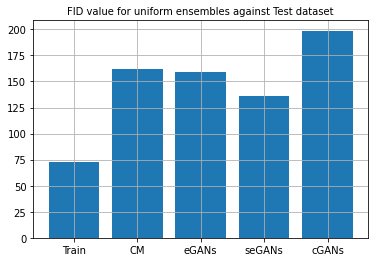

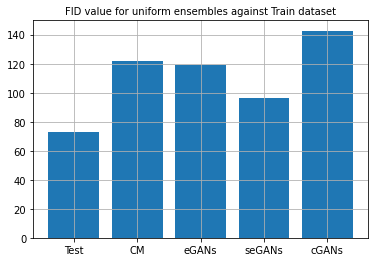

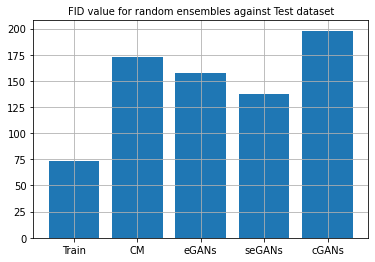

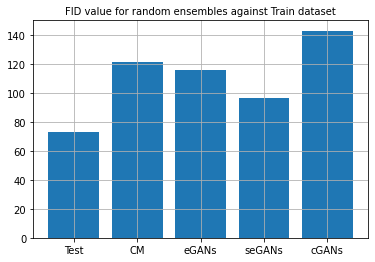

In [32]:
def chartbar(title, labels, values):
    plt.bar(labels, values)
    plt.title(title, fontsize=10)
    plt.xticks(labels, fontsize=10)
    plt.grid(True)
    plt.show()

# Control Model (CM)
# Standard Ensemble of GANs (eGANs)
# Self-ensemble of GANs (seGANs)
# Cascade of GANs (cGANs)

models_test = ['Train', 'CM', 'eGANs', 'seGANs', 'cGANs']
models_test_res = [72.96460308701032, 161.84549324868163, 159.03607541358565, 136.45839914801348, 198.69353282806986]
chartbar('FID value for uniform ensembles against Test dataset', models_test, models_test_res)

models_train = ['Test', 'CM', 'eGANs', 'seGANs', 'cGANs']
models_train_res = [72.96460291447087, 121.5682668817646, 118.98872088310006, 96.07424449112393, 142.71356008760276]
chartbar('FID value for uniform ensembles against Train dataset', models_train, models_train_res)

models_rand_test = ['Train', 'CM', 'eGANs', 'seGANs', 'cGANs']
models_rand_test_res = [72.96460308701032, 172.6491870902122, 157.22691132361095, 137.62859819167787, 197.93667106533925]
chartbar('FID value for random ensembles against Test dataset', models_rand_test, models_rand_test_res)

models_rand_train = ['Test', 'CM', 'eGANs', 'seGANs', 'cGANs']
models_rand_train_res = [72.96460291447087, 121.5682668817646, 115.87657582247158, 96.60418049224069, 143.05082773638085]
chartbar('FID value for random ensembles against Train dataset', models_rand_train, models_rand_train_res)

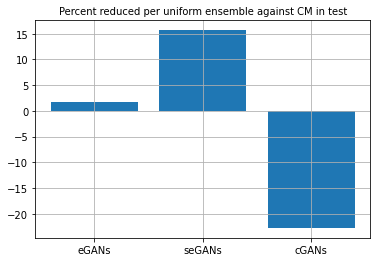

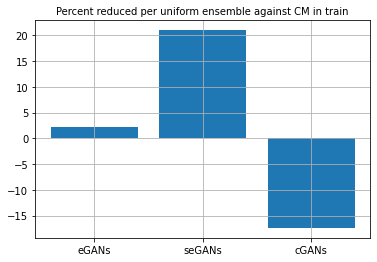

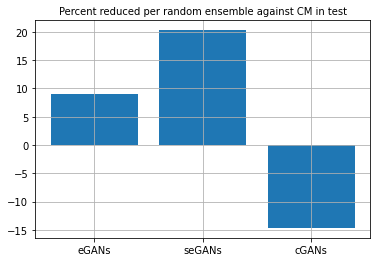

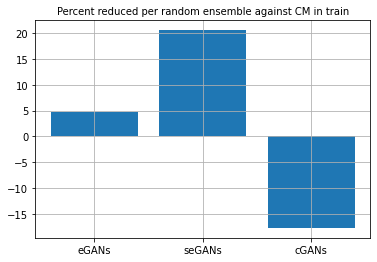

([54.91712396656144,
  0.0,
  1.7358641125577776,
  15.686006197070895,
  -22.767417763539356],
 [39.9805518446396,
  0.0,
  2.1218909052749524,
  20.970951585116993,
  -17.393760516799787],
 [57.73822957597533,
  1.4210854715202004e-14,
  8.932724229128766,
  20.28424777942074,
  -14.646743724263189],
 [39.9805518446396,
  0.0,
  4.681888789965782,
  20.53503519450811,
  -17.671191179775434])

In [44]:
def percent_list(values, denomi):
    return [100-(val*100)/denomi for val in values]

percent_uni_test = percent_list(models_test_res, models_test_res[1])
percent_uni_train = percent_list(models_train_res, models_train_res[1])
percent_rand_test = percent_list(models_rand_test_res, models_rand_test_res[1])
percent_rand_train = percent_list(models_rand_train_res, models_rand_train_res[1])

models_list = ['eGANs', 'seGANs', 'cGANs']
chartbar('Percent reduced per uniform ensemble against CM in test', models_list, percent_uni_test[2:])
chartbar('Percent reduced per uniform ensemble against CM in train', models_list, percent_uni_train[2:])
chartbar('Percent reduced per random ensemble against CM in test', models_list, percent_rand_test[2:])
chartbar('Percent reduced per random ensemble against CM in train', models_list, percent_rand_train[2:])

percent_uni_test, percent_uni_train, percent_rand_test, percent_rand_train

### Conclusion

* After generating images using control model and all ensembles, reformatting real images from test and train datasets into the same as generated images, and then generating Fréchet Inception Distance metrics comparing all these groups, we can see that results in the paper [Ensembles of Generative Adversarial Networks](https://arxiv.org/pdf/1612.00991.pdf) were replicated, where the best ensemble was seGANs, followed up by eGANs, which performed better than the single DCGAN from the control model, in terms of less distance, less difference between generated images from those models than real images, from both test and train set.

* EM1 or eGANs: Generating images with eGANs by randomly choosing a model in the ensemble, performed better than the control model and even better than itself when generating images uniformly choosing GANs in the ensemble, between 5% and 9% better.

* EM2 or seGANs: Generating images with seGANs by randomly choosing a model in the ensemble, performed better than control model and even better than itself when generating images uniformly choosing GANs in the ensemble, the same that happened with eGANS, but the improvements was even higher, around 20% better than single DCGAN control model.

* EM3 or Cascade of GANs: was outperformed even by the single DCGAN control model, probably because of the issue of having too small dataset, in which only one GAN was trained using the whole set of images and the rest was having a reduced space for training.

